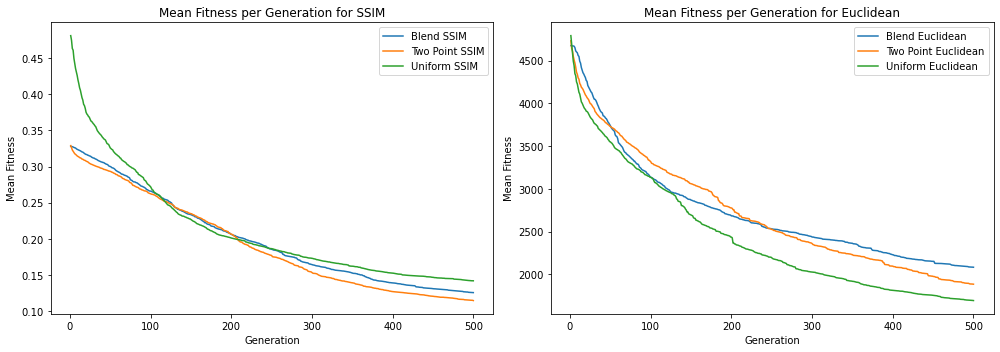

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def process_fitness_file(filename):
    with open(filename, "r") as file:
        fitness_values = [float(line.strip()) for line in file]

    num_generations_per_run = 500
    num_runs = len(fitness_values) // num_generations_per_run

    fitness_values = np.array(fitness_values)
    fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)
    
    mean_fitness_per_generation = np.mean(fitness_values, axis=0)
    
    return mean_fitness_per_generation

mean_fitness_blend_ssim = process_fitness_file("fitness_values_blend.txt")
mean_fitness_blend_euclidean = process_fitness_file("fitness_values_euclidean_blend.txt")

mean_fitness_2PC_ssim = process_fitness_file("fitness_values_2PC.txt")
mean_fitness_2PC_euclidean = process_fitness_file("fitness_values_euclidean.txt")

mean_fitness_uniform_ssim = process_fitness_file("fitness_values_uniform.txt")
mean_fitness_uniform_euclidean = process_fitness_file("fitness_values_euclidean_uniform.txt")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot SSIM curves in the first subplot
axs[0].plot(range(1, 501), mean_fitness_blend_ssim, label='Blend SSIM')
axs[0].plot(range(1, 501), mean_fitness_2PC_ssim, label='Two Point SSIM')
axs[0].plot(range(1, 501), mean_fitness_uniform_ssim, label='Uniform SSIM')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Fitness')
axs[0].set_title('Mean Fitness per Generation for SSIM')
axs[0].legend()

# Plot Euclidean curves in the second subplot
axs[1].plot(range(1, 501), mean_fitness_blend_euclidean, label='Blend Euclidean')
axs[1].plot(range(1, 501), mean_fitness_2PC_euclidean, label='Two Point Euclidean')
axs[1].plot(range(1, 501), mean_fitness_uniform_euclidean, label='Uniform Euclidean')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Fitness')
axs[1].set_title('Mean Fitness per Generation for Euclidean')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [2]:
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

In [5]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGB", (self._img_width, self._img_height), (255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image)
    rendered_image = np.array(painting.draw())
    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum((target_array - rendered_image) ** 2))
    return distance

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = child2.triangles[i], child1.triangles[i]

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 150
generations = 1000
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_euclidean_uniform_tuned.txt"

#for run in range(1):
    #print(f"Run {run + 1}")
    
target_image_path = 'target_image.png'
target_image = Image.open(target_image_path).convert('RGB')
img_width, img_height = target_image.size

color_extractor = Color(target_image_path, num_colors=10)
palette = color_extractor.palette

population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

with open(fitness_file, "a") as file:
    for fitness in population.fitness_history:
        file.write(f"{fitness}\n")

Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [108 108 108]
 [123  68   0]
 [187 187 187]
 [ 69  69  69]
 [147 147 147]
 [224 224 224]
 [ 36  30  23]]
Generation 1, Best Fitness: 5407.563222006748
Generation 2, Best Fitness: 5336.3367584889165
Generation 3, Best Fitness: 5293.600570500196
Generation 4, Best Fitness: 5157.124198620778
Generation 5, Best Fitness: 5047.690759149177
Generation 6, Best Fitness: 5039.387065903948
Generation 7, Best Fitness: 4920.9373090906165
Generation 8, Best Fitness: 4860.613232916193
Generation 9, Best Fitness: 4756.939877694483
Generation 10, Best Fitness: 4729.6228179422515
Generation 11, Best Fitness: 4672.46958256552
Generation 12, Best Fitness: 4613.413811918458
Generation 13, Best Fitness: 4533.664853074166
Generation 14, Best Fitness: 4492.502420700516
Generation 15, Best Fitness: 4453.313934588488
Generation 16, Best Fitness: 4429.699199719999
Generation 17, Best Fitness: 4398.348894755849
Generation 18, Best Fitness: 4332.1345

Generation 169, Best Fitness: 2760.9112626087785
Generation 170, Best Fitness: 2759.401927954679
Generation 171, Best Fitness: 2758.6375260262084
Generation 172, Best Fitness: 2758.6282823171373
Generation 173, Best Fitness: 2753.846764073847
Generation 174, Best Fitness: 2753.3592210243837
Generation 175, Best Fitness: 2747.544358149655
Generation 176, Best Fitness: 2747.544358149655
Generation 177, Best Fitness: 2742.6441621180097
Generation 178, Best Fitness: 2740.7582892331093
Generation 179, Best Fitness: 2740.7582892331093
Generation 180, Best Fitness: 2736.6373526647626
Generation 181, Best Fitness: 2733.8483864325763
Generation 182, Best Fitness: 2731.4485168130113
Generation 183, Best Fitness: 2729.081164055038
Generation 184, Best Fitness: 2727.477222636332
Generation 185, Best Fitness: 2727.477222636332
Generation 186, Best Fitness: 2721.5638886493184
Generation 187, Best Fitness: 2716.9777327022757
Generation 188, Best Fitness: 2714.721532680654
Generation 189, Best Fitness

Generation 338, Best Fitness: 2162.351729020975
Generation 339, Best Fitness: 2157.183812288605
Generation 340, Best Fitness: 2154.4163942933596
Generation 341, Best Fitness: 2147.980214061573
Generation 342, Best Fitness: 2147.980214061573
Generation 343, Best Fitness: 2147.056124091776
Generation 344, Best Fitness: 2140.554133863472
Generation 345, Best Fitness: 2082.226932877394
Generation 346, Best Fitness: 2057.059065753825
Generation 347, Best Fitness: 2057.059065753825
Generation 348, Best Fitness: 2057.059065753825
Generation 349, Best Fitness: 2055.552237234559
Generation 350, Best Fitness: 2054.4437203291795
Generation 351, Best Fitness: 2052.5574291600224
Generation 352, Best Fitness: 2048.397910563277
Generation 353, Best Fitness: 2047.7468105212618
Generation 354, Best Fitness: 2045.0726148476979
Generation 355, Best Fitness: 2043.8688803345483
Generation 356, Best Fitness: 2043.036955123426
Generation 357, Best Fitness: 2037.8800259092782
Generation 358, Best Fitness: 203

Generation 507, Best Fitness: 1771.1216784851345
Generation 508, Best Fitness: 1770.3923294004637
Generation 509, Best Fitness: 1768.8640422598905
Generation 510, Best Fitness: 1768.2166156893786
Generation 511, Best Fitness: 1767.2979375306247
Generation 512, Best Fitness: 1767.2979375306247
Generation 513, Best Fitness: 1767.2979375306247
Generation 514, Best Fitness: 1767.2979375306247
Generation 515, Best Fitness: 1766.2864999767166
Generation 516, Best Fitness: 1766.2864999767166
Generation 517, Best Fitness: 1765.7063742310045
Generation 518, Best Fitness: 1765.2603207459233
Generation 519, Best Fitness: 1764.063490920891
Generation 520, Best Fitness: 1764.063490920891
Generation 521, Best Fitness: 1763.4877374112925
Generation 522, Best Fitness: 1759.5672763495006
Generation 523, Best Fitness: 1759.5672763495006
Generation 524, Best Fitness: 1757.9655855562132
Generation 525, Best Fitness: 1757.9655855562132
Generation 526, Best Fitness: 1757.4800141111136
Generation 527, Best F

Generation 675, Best Fitness: 1586.255654048237
Generation 676, Best Fitness: 1585.862226046134
Generation 677, Best Fitness: 1585.862226046134
Generation 678, Best Fitness: 1585.862226046134
Generation 679, Best Fitness: 1585.8187159949905
Generation 680, Best Fitness: 1585.1659219148007
Generation 681, Best Fitness: 1584.408722520802
Generation 682, Best Fitness: 1583.6038014604537
Generation 683, Best Fitness: 1582.9399862281577
Generation 684, Best Fitness: 1582.9399862281577
Generation 685, Best Fitness: 1582.9238768810078
Generation 686, Best Fitness: 1580.492328358477
Generation 687, Best Fitness: 1580.492328358477
Generation 688, Best Fitness: 1580.0281643059404
Generation 689, Best Fitness: 1580.0281643059404
Generation 690, Best Fitness: 1580.0281643059404
Generation 691, Best Fitness: 1580.0281643059404
Generation 692, Best Fitness: 1579.6312860917892
Generation 693, Best Fitness: 1579.6084957988799
Generation 694, Best Fitness: 1578.404257470183
Generation 695, Best Fitness

Generation 844, Best Fitness: 1476.9102884061713
Generation 845, Best Fitness: 1476.9102884061713
Generation 846, Best Fitness: 1476.9102884061713
Generation 847, Best Fitness: 1476.2960407723108
Generation 848, Best Fitness: 1476.1476890880533
Generation 849, Best Fitness: 1476.1476890880533
Generation 850, Best Fitness: 1473.9898235740977
Generation 851, Best Fitness: 1473.9562408701283
Generation 852, Best Fitness: 1473.9562408701283
Generation 853, Best Fitness: 1473.0604196705578
Generation 854, Best Fitness: 1472.0730280797893
Generation 855, Best Fitness: 1471.2107258989108
Generation 856, Best Fitness: 1471.2107258989108
Generation 857, Best Fitness: 1471.2107258989108
Generation 858, Best Fitness: 1470.8626720397795
Generation 859, Best Fitness: 1470.8626720397795
Generation 860, Best Fitness: 1470.8626720397795
Generation 861, Best Fitness: 1470.802502037578
Generation 862, Best Fitness: 1470.802502037578
Generation 863, Best Fitness: 1470.802502037578
Generation 864, Best Fi

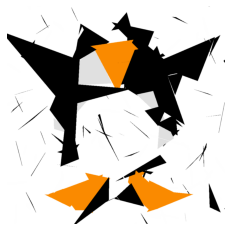

In [6]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

In [7]:
population_size = 50
num_triangles = 200
generations = 1000
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True
   
target_image_path = 'target_image.png'
target_image = Image.open(target_image_path).convert('RGB')
img_width, img_height = target_image.size

color_extractor = Color(target_image_path, num_colors=10)
palette = color_extractor.palette

population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

Extracted palette: [[  0   0   0]
 [254 254 254]
 [250 138   0]
 [ 86  86  86]
 [119  66   0]
 [184 184 184]
 [ 41  36  31]
 [137 137 137]
 [224 224 224]
 [223 123   0]]
Generation 1, Best Fitness: 6079.465848246868
Generation 2, Best Fitness: 5901.412288596688
Generation 3, Best Fitness: 5735.094332266907
Generation 4, Best Fitness: 5735.094332266907
Generation 5, Best Fitness: 5564.3876572359695
Generation 6, Best Fitness: 5442.589916574645
Generation 7, Best Fitness: 5406.898556473942
Generation 8, Best Fitness: 5352.827944180533
Generation 9, Best Fitness: 5054.256424044985
Generation 10, Best Fitness: 5054.256424044985
Generation 11, Best Fitness: 5054.256424044985
Generation 12, Best Fitness: 4950.7077271840635
Generation 13, Best Fitness: 4950.7077271840635
Generation 14, Best Fitness: 4856.03552293432
Generation 15, Best Fitness: 4856.03552293432
Generation 16, Best Fitness: 4820.376022677069
Generation 17, Best Fitness: 4820.376022677069
Generation 18, Best Fitness: 4745.63199

Generation 170, Best Fitness: 2639.1508103933734
Generation 171, Best Fitness: 2631.167421507039
Generation 172, Best Fitness: 2627.219252365512
Generation 173, Best Fitness: 2619.3489649147555
Generation 174, Best Fitness: 2619.3489649147555
Generation 175, Best Fitness: 2612.2442458545106
Generation 176, Best Fitness: 2605.895623389394
Generation 177, Best Fitness: 2602.631744984296
Generation 178, Best Fitness: 2598.128557250391
Generation 179, Best Fitness: 2583.379763023625
Generation 180, Best Fitness: 2581.6159667928923
Generation 181, Best Fitness: 2576.0743389894633
Generation 182, Best Fitness: 2572.4707967244253
Generation 183, Best Fitness: 2570.2064119443794
Generation 184, Best Fitness: 2554.7496941970658
Generation 185, Best Fitness: 2536.3337714110103
Generation 186, Best Fitness: 2533.027832456643
Generation 187, Best Fitness: 2533.027832456643
Generation 188, Best Fitness: 2522.9946492214367
Generation 189, Best Fitness: 2521.1695698623685
Generation 190, Best Fitness

Generation 339, Best Fitness: 1950.8434073497544
Generation 340, Best Fitness: 1948.8024527899179
Generation 341, Best Fitness: 1945.6112150170188
Generation 342, Best Fitness: 1945.2431724594228
Generation 343, Best Fitness: 1945.2431724594228
Generation 344, Best Fitness: 1945.2431724594228
Generation 345, Best Fitness: 1945.2431724594228
Generation 346, Best Fitness: 1943.5989812715998
Generation 347, Best Fitness: 1937.801589430662
Generation 348, Best Fitness: 1937.3848352869907
Generation 349, Best Fitness: 1937.3848352869907
Generation 350, Best Fitness: 1937.3848352869907
Generation 351, Best Fitness: 1931.623669351771
Generation 352, Best Fitness: 1931.623669351771
Generation 353, Best Fitness: 1931.623669351771
Generation 354, Best Fitness: 1930.6820038525248
Generation 355, Best Fitness: 1930.6820038525248
Generation 356, Best Fitness: 1929.8950748680613
Generation 357, Best Fitness: 1924.3536577251075
Generation 358, Best Fitness: 1924.3536577251075
Generation 359, Best Fit

Generation 507, Best Fitness: 1727.09872329291
Generation 508, Best Fitness: 1726.9832077932895
Generation 509, Best Fitness: 1726.1370165777687
Generation 510, Best Fitness: 1726.1370165777687
Generation 511, Best Fitness: 1725.659004554492
Generation 512, Best Fitness: 1724.6277859294742
Generation 513, Best Fitness: 1723.2733387364872
Generation 514, Best Fitness: 1723.2733387364872
Generation 515, Best Fitness: 1722.82848827154
Generation 516, Best Fitness: 1722.82848827154
Generation 517, Best Fitness: 1722.82848827154
Generation 518, Best Fitness: 1722.3190761296235
Generation 519, Best Fitness: 1722.3190761296235
Generation 520, Best Fitness: 1722.3190761296235
Generation 521, Best Fitness: 1718.8391431428363
Generation 522, Best Fitness: 1714.550086757456
Generation 523, Best Fitness: 1713.5542010686443
Generation 524, Best Fitness: 1710.034210184112
Generation 525, Best Fitness: 1710.034210184112
Generation 526, Best Fitness: 1710.034210184112
Generation 527, Best Fitness: 171

Generation 675, Best Fitness: 1603.9071045419057
Generation 676, Best Fitness: 1603.9071045419057
Generation 677, Best Fitness: 1601.8804574624162
Generation 678, Best Fitness: 1601.8804574624162
Generation 679, Best Fitness: 1601.8804574624162
Generation 680, Best Fitness: 1600.691725473709
Generation 681, Best Fitness: 1600.0343746307453
Generation 682, Best Fitness: 1600.0343746307453
Generation 683, Best Fitness: 1597.924591462313
Generation 684, Best Fitness: 1597.924591462313
Generation 685, Best Fitness: 1596.5096304125448
Generation 686, Best Fitness: 1595.3247318336164
Generation 687, Best Fitness: 1595.3247318336164
Generation 688, Best Fitness: 1594.0301126390304
Generation 689, Best Fitness: 1593.4343412892795
Generation 690, Best Fitness: 1593.4343412892795
Generation 691, Best Fitness: 1593.4343412892795
Generation 692, Best Fitness: 1593.0932176115746
Generation 693, Best Fitness: 1592.502119307852
Generation 694, Best Fitness: 1592.2813821683653
Generation 695, Best Fit

Generation 844, Best Fitness: 1533.6450045561392
Generation 845, Best Fitness: 1531.4062165212729
Generation 846, Best Fitness: 1531.4062165212729
Generation 847, Best Fitness: 1531.3964215708486
Generation 848, Best Fitness: 1529.889211675146
Generation 849, Best Fitness: 1529.889211675146
Generation 850, Best Fitness: 1528.1465898270362
Generation 851, Best Fitness: 1528.1465898270362
Generation 852, Best Fitness: 1527.6550657789212
Generation 853, Best Fitness: 1527.2046359280082
Generation 854, Best Fitness: 1527.08283992716
Generation 855, Best Fitness: 1527.08283992716
Generation 856, Best Fitness: 1527.07203497412
Generation 857, Best Fitness: 1527.0664687563537
Generation 858, Best Fitness: 1527.0664687563537
Generation 859, Best Fitness: 1526.0439050040468
Generation 860, Best Fitness: 1525.1219623361274
Generation 861, Best Fitness: 1525.1219623361274
Generation 862, Best Fitness: 1520.4380947608488
Generation 863, Best Fitness: 1520.4302022782895
Generation 864, Best Fitness

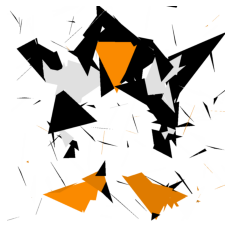

In [8]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

# este não está corrido 

In [ ]:
population_size = 50
num_triangles = 150
generations = 1500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True
   
target_image_path = 'target_image.png'
target_image = Image.open(target_image_path).convert('RGB')
img_width, img_height = target_image.size

color_extractor = Color(target_image_path, num_colors=10)
palette = color_extractor.palette

population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 85  85  85]
 [181 181 181]
 [119  66   0]
 [ 41  36  31]
 [222 222 222]
 [135 135 135]
 [223 123   0]]
Generation 1, Best Fitness: 5326.624447058381
Generation 2, Best Fitness: 5219.649413514283
Generation 3, Best Fitness: 5113.195282795289
Generation 4, Best Fitness: 5020.811886537874
Generation 5, Best Fitness: 4899.4682364517885
Generation 6, Best Fitness: 4899.4682364517885
Generation 7, Best Fitness: 4877.224825656492
Generation 8, Best Fitness: 4845.030546859328
Generation 9, Best Fitness: 4754.697887353097
Generation 10, Best Fitness: 4671.470111217667
Generation 11, Best Fitness: 4648.185237272714
Generation 12, Best Fitness: 4605.13680578547
Generation 13, Best Fitness: 4550.899471533073
Generation 14, Best Fitness: 4443.734803068248
Generation 15, Best Fitness: 4400.3519177447615
Generation 16, Best Fitness: 4246.428028355126
Generation 17, Best Fitness: 4246.428028355126
Generation 18, Best Fitness: 4222.3164

Generation 169, Best Fitness: 2534.213290155349
Generation 170, Best Fitness: 2534.213290155349
Generation 171, Best Fitness: 2531.7748715081284
Generation 172, Best Fitness: 2528.303976977452
Generation 173, Best Fitness: 2528.303976977452
Generation 174, Best Fitness: 2527.152745680403
Generation 175, Best Fitness: 2524.4460778554967
Generation 176, Best Fitness: 2522.812517806268
Generation 177, Best Fitness: 2519.6424349498484
Generation 178, Best Fitness: 2519.6424349498484
Generation 179, Best Fitness: 2515.9326302586087
Generation 180, Best Fitness: 2512.354871430388
Generation 181, Best Fitness: 2512.354871430388
Generation 182, Best Fitness: 2511.8186638370216
Generation 183, Best Fitness: 2493.853243476849
Generation 184, Best Fitness: 2488.3526679311353
Generation 185, Best Fitness: 2488.3526679311353
Generation 186, Best Fitness: 2482.4264339552947
Generation 187, Best Fitness: 2482.4264339552947
Generation 188, Best Fitness: 2480.8700086864687
Generation 189, Best Fitness:

Generation 338, Best Fitness: 1912.9634079093098
Generation 339, Best Fitness: 1912.9634079093098
Generation 340, Best Fitness: 1912.1736322834283
Generation 341, Best Fitness: 1911.6968901999082
Generation 342, Best Fitness: 1911.16718263997
Generation 343, Best Fitness: 1899.3317245810433
Generation 344, Best Fitness: 1899.3317245810433
Generation 345, Best Fitness: 1897.845093784
Generation 346, Best Fitness: 1891.5287468077242
Generation 347, Best Fitness: 1891.5287468077242
Generation 348, Best Fitness: 1891.4298823905685
Generation 349, Best Fitness: 1890.2809315019817
Generation 350, Best Fitness: 1888.647929075189
Generation 351, Best Fitness: 1888.2033788763329
Generation 352, Best Fitness: 1886.0697229954146
Generation 353, Best Fitness: 1883.1099277524931
Generation 354, Best Fitness: 1883.1099277524931
Generation 355, Best Fitness: 1880.712099179457
Generation 356, Best Fitness: 1879.612726068857
Generation 357, Best Fitness: 1878.104895899055
Generation 358, Best Fitness: 

Generation 507, Best Fitness: 1691.7869251179359
Generation 508, Best Fitness: 1691.6078150682563
Generation 509, Best Fitness: 1691.0759888307798
Generation 510, Best Fitness: 1690.3768810534532
Generation 511, Best Fitness: 1689.3850952343578
Generation 512, Best Fitness: 1689.3850952343578
Generation 513, Best Fitness: 1687.864331040857
Generation 514, Best Fitness: 1687.25161134906
Generation 515, Best Fitness: 1687.2415357618481
Generation 516, Best Fitness: 1685.6007831037573
Generation 517, Best Fitness: 1685.6007831037573
Generation 518, Best Fitness: 1684.8985132642263
Generation 519, Best Fitness: 1684.4435282905747
Generation 520, Best Fitness: 1684.4435282905747
Generation 521, Best Fitness: 1683.8414414665058
Generation 522, Best Fitness: 1683.7449331772316
Generation 523, Best Fitness: 1683.6101092592667
Generation 524, Best Fitness: 1681.9937574200446
Generation 525, Best Fitness: 1679.1387673447362
Generation 526, Best Fitness: 1679.0768296894576
Generation 527, Best Fi